# Lab Assignment 2 - Part C: Naive Bayes for Spam Detection
Please refer to the `README.pdf` for full laboratory instructions.


## Problem Statement
In this part, you will implement a **Naive Bayes classifier** for spam email detection using the Spambase dataset.

### Dataset Description
The Spambase dataset contains 4601 email samples with 57 features:
- **Features 1-48**: Word frequencies (percentage of words matching specific words)
- **Features 49-54**: Character frequencies (`;`, `(`, `[`, `!`, `$`, `#`)
- **Features 55-57**: Capital letter statistics
- **Label**: 1 = spam, 0 = not spam

### Your Tasks
1. **Implement Gaussian Naive Bayes** from scratch
2. **Train and evaluate** your classifier (accuracy, precision, recall, F1-score)
3. **Feature analysis**: Identify top discriminative features
4. **Discussion**: Why does Naive Bayes work for spam detection?


## Setup


In [20]:
%pip install ucimlrepo


Note: you may need to restart the kernel to use updated packages.


In [21]:
# Library declarations
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo


## Load the Spambase Dataset


In [22]:
# Fetch Spambase dataset from UCI ML Repository
spambase = fetch_ucirepo(id=94)

# Get features and labels
X = spambase.data.features.values
y = spambase.data.targets.values.ravel()

print(f"Dataset shape: {X.shape}")
print(f"Number of spam emails: {np.sum(y == 1)}")
print(f"Number of non-spam emails: {np.sum(y == 0)}")
print(f"\nFeature names: {list(spambase.data.features.columns[:10])}...")  # First 10 features


Dataset shape: (4601, 57)
Number of spam emails: 1813
Number of non-spam emails: 2788

Feature names: ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail']...


In [23]:
# Split data into training (80%) and testing (20%) sets
def train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split data into training and testing sets.
    """
    np.random.seed(random_state)
    n_samples = len(y)
    indices = np.random.permutation(n_samples)
    test_size = int(n_samples * test_size)
    
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")


Training set: 3681 samples
Testing set: 920 samples


## Task 1: Implement Gaussian Naive Bayes
Implement a Gaussian Naive Bayes classifier from scratch.

**Key formulas:**
- Class prior: $P(C) = \frac{N_C}{N}$
- Gaussian likelihood: $P(x_i|C) = \frac{1}{\sqrt{2\pi\sigma_{i,C}^2}} \exp\left(-\frac{(x_i - \mu_{i,C})^2}{2\sigma_{i,C}^2}\right)$
- Use **log-probabilities** to avoid numerical underflow!


In [ ]:
class GaussianNaiveBayes:
    """
    Gaussian Naive Bayes classifier implementation.
    """
    
    def __init__(self):
        self.classes = None
        self.priors = None      # P(C) for each class
        self.means = None       # Mean of each feature per class
        self.variances = None   # Variance of each feature per class
    
    def fit(self, X, y):
        """
        Train the Naive Bayes classifier.
        
        Parameters:
        -----------
        X : numpy array of shape (n_samples, n_features)
        y : numpy array of shape (n_samples,)
        """
        X = np.asarray(X)
        y = np.asarray(y)

        # 1. Get unique classes
        self.classes, counts = np.unique(y, return_counts=True)
        
        # 2. Calculate class priors P(C)
        self.priors = counts / np.sum(counts)
        
        # 3. Calculate mean and variance for each feature per class
        n_classes = len(self.classes)
        n_features = X.shape[1]
        self.means = np.zeros((n_classes, n_features))
        self.variances = np.zeros((n_classes, n_features))
        
        epsilon = 0.000000000001
        
        for i, class_ in enumerate(self.classes):
            X_class = X[y == class_]
            self.means[i] = np.mean(X_class, axis=0)
            self.variances[i] = np.var(X_class, axis=0) + epsilon
    
    def _gaussian_log_likelihood(self, x, mean, var):
        """
        Calculate log of Gaussian probability density.
        
        Returns:
        --------
        log_likelihood : float
        """
        return -0.5 * np.log(2*np.pi*var) - 0.5 * (x - mean)**2 / var
    
    def predict(self, X):
        """
        Predict class labels for samples in X.
        
        Parameters:
        -----------
        X : numpy array of shape (n_samples, n_features)
        
        Returns:
        --------
        predictions : numpy array of shape (n_samples,)
        """
        predictions = np.empty(X.shape[0], dtype=int)
        for sample_ix, sample in enumerate(X):
            class_predictions = np.empty(len(self.classes), dtype=float)
            for class_ix, class_ in enumerate(self.classes):
                likelihood_sum = 0
                for feature_ix in range(len(sample)):
                    likelihood_sum += self._gaussian_log_likelihood(sample[feature_ix], self.means[class_ix, feature_ix], self.variances[class_ix, feature_ix])
                class_predictions[class_ix] = np.log(self.priors[class_ix]) + likelihood_sum
            predictions[sample_ix] = self.classes[np.argmax(class_predictions)]
        
        return predictions
    
    def predict_proba(self, X):
        """
        Return probability estimates for samples.
        
        Returns:
        --------
        probabilities : numpy array of shape (n_samples, n_classes)
        """
        # TODO: (Optional) Implement probability estimation
        pass
    

## Task 2: Train and Evaluate
Train your classifier and compute evaluation metrics.


In [25]:
def compute_metrics(y_true, y_pred):
    """
    Compute classification metrics.
    
    Returns:
    --------
    accuracy, precision, recall, f1_score : floats
    """
    TP = np.sum((y_pred == 1) & (y_true == 1))
    TN = np.sum((y_pred == 0) & (y_true == 0))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    return accuracy, precision, recall, f1


def confusion_matrix(y_true, y_pred):
    """
    Create confusion matrix.
    
    Returns:
    --------
    matrix : numpy array of shape (2, 2)
        [[TN, FP], [FN, TP]]
    """
    TN = np.sum((y_pred == 0) & (y_true == 0))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    TP = np.sum((y_pred == 1) & (y_true == 1))
    
    return np.array([[TN, FP], [FN, TP]])

## Task 3: Feature Analysis
Identify the most discriminative features for spam detection.


In [26]:
# TODO: Train your classifier
nb_classifier = GaussianNaiveBayes()
nb_classifier.fit(X_train, y_train)

# TODO: Make predictions
y_pred = nb_classifier.predict(X_test)

# TODO: Compute and print metrics
accuracy, precision, recall, f1 = compute_metrics(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)


Accuracy: 0.8217
Precision: 0.7233
Recall: 0.9385
F1-Score: 0.8170

Confusion Matrix:
[[390 140]
 [ 24 366]]


In [ ]:
# Identify top 5 most discriminative features
feature_names = list(spambase.data.features.columns)
discriminative_scores = []

for i in range(X.shape[1]):
    X_nonspam = X[y == 0, i]
    X_spam = X[y == 1, i]
    
    nospam_mean = np.mean(X_nonspam)
    spam_mean = np.mean(X_spam)
    diff = abs(nospam_mean - spam_mean)
    
    # Pooled STD
    nospam_var = np.var(X_nonspam)
    spam_var = np.var(X_spam)
    pooled_std = np.sqrt((nospam_var + spam_var) / 2.0)
    
    discriminative_scores.append(diff / pooled_std)

discriminative_scores = np.array(discriminative_scores)
# [::-1] reverses and we take the top 5
top_5_indices = np.argsort(discriminative_scores)[::-1][:5]

print("Top 5 most discriminative features:")
for i, idx in enumerate(top_5_indices):
    print(f"{i+1}. {feature_names[idx]}: score = {discriminative_scores[idx]}")

Top 5 most discriminative features:
1. word_freq_your: score = 0.8329378255637868
2. word_freq_000: score = 0.6483703730675483
3. word_freq_remove: score = 0.6458372141909565
4. char_freq_$: score = 0.6273778306921672
5. word_freq_hp: score = 0.5978013816482303


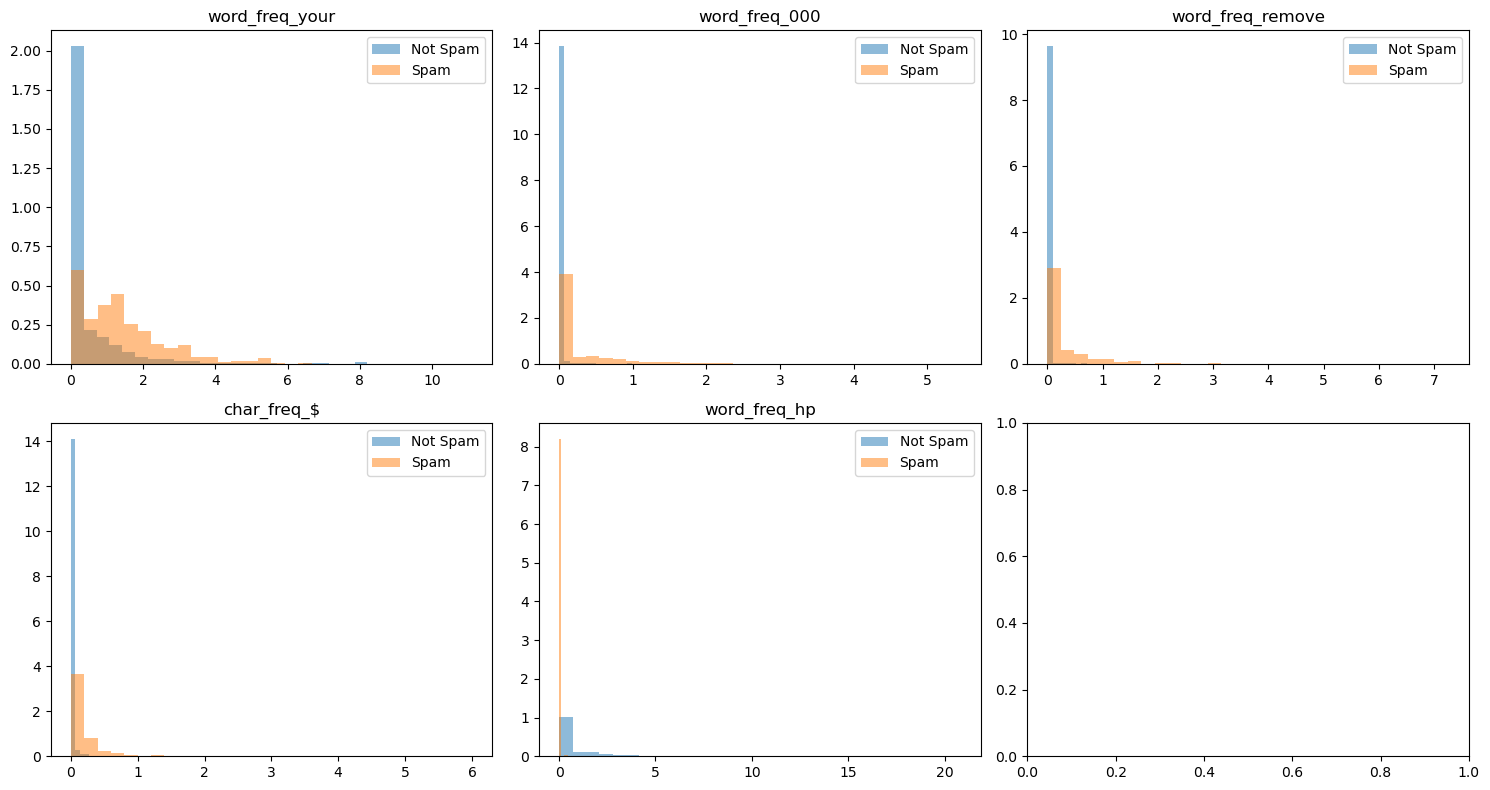

In [35]:
# TODO: Visualize distributions of top features for spam vs non-spam
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, idx in enumerate(top_5_indices[:5]):
     ax = axes[i // 3, i % 3]
     ax.hist(X[y == 0, idx], bins=30, alpha=0.5, label='Not Spam', density=True)
     ax.hist(X[y == 1, idx], bins=30, alpha=0.5, label='Spam', density=True)
     ax.set_title(f'{feature_names[idx]}')
     ax.legend()
plt.tight_layout()
plt.show()


## Summary and Discussion

### Results Table
| Metric | Value |
|--------|-------|
| Accuracy | 0.8217 |
| Precision | 0.7233 |
| Recall | 0.9385 |
| F1-Score | 0.8170 |

### Top 5 Discriminative Features
1. word_freq_your: score = 0.8329378255637868
2. word_freq_000: score = 0.6483703730675483
3. word_freq_remove: score = 0.6458372141909565
4. char_freq_$: score = 0.6273778306921672
5. word_freq_hp: score = 0.5978013816482303

### Discussion

**1. Why is Naive Bayes effective for spam detection despite the independence assumption?**

Naive Bayes assumes the conditional probabilities are independent when in reality they are not. However, it works well because: Individual word frequencies are highly predictive: Certain words (like "viagra", "click here", "$$$") appear overwhelmingly in spam. Even though the assumption is wrong, these strong signals dominate the prediction. Morever, we have probabilistic averaging: the classifier averages probabilities across all 57 features. Even if some correlations are missed, the cumulative effect of many weak signals remains accurate.

Also spam is probably characterized by the presence of suspicious words rather than their relationship, making independence a reasonable approximation in practice.

**2. What are the limitations of your implementation?**

It is a Naive Classifier oversimplifying what constitutes a spam/non-spam email. It ignores word order and context and treats each feature independently, so "not spam" vs "SPAM" would have similar feature values. It also assumes Gaussian distribution with equal variance per class—real word frequencies may be skewed or multi-modal. 

We shoudl also consider how spam evolves over time, but the model learns static word frequencies. This would have to constantly be udpated. 

**3. How could you improve the classifier?**

Preprocessing: Normalize/standardize features to improve variance estimates

Ensemble methods: Combine with Random Forest or SVM for better decision boundaries. 

**4. What did you learn from this exercise?**
Sometimes Occam's Razor is a sufficient approach. I learned to start simple and realized that even with a naive assumption, we can develop a baseline performance. 

*However, our precision is particularly low hovering around 0.7. False positives in email classification is particularly harmful. I cannot imagine how I would feel if I had a Jane Street Final Round interview email that was sent to spam.*